In [1]:
from collections import deque
import logging

from matplotlib import rc
from numpy import exp, inf, log
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt

## Config

In [2]:
# logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# matplotlib
plt.rc('text', usetex=True)

## Parameters

In [3]:
MAXTIME = 5000
DEFAULT_LAMBDA = 1
DEFAULT_MU = 2
DEFAULT_C = 1

## Random Variable Helpers

In [4]:
def gen_exp_rv(ld):
    return -1 / ld * log(1 - rand()) # using inverse CDF of exp RVs

## Classes

### Stall
Handles queue and departure of customers

Including whether or not customer joins, according to this formula


Let $c \in [0, 1]$, where $c$ is a parameter of the simulation determining the willingness of a random customer to queue.

Let q be the queue length

\begin{align*}
\text{Queue joined} = \begin{cases} 
      \text{Joined} & \text{if }U(0, 1) \leq c^{q}\\
      \text{Not joined} & \text{o.w.}\\
   \end{cases}
\end{align*}

In [5]:
class Stall:
    def __init__(self, simulator, c, mu):
        self.c = c
        self.mu = mu
        self.simulator = simulator
        self.queue = deque([])
        self._departure_times = deque([])
        
    def add_customer(self, customer):
        def gen_departure_time():
            if not self._departure_times:
                return gen_exp_rv(self.mu) + self.simulator.time
            else:
                return gen_exp_rv(self.mu) + max(
                    self._departure_times[-1],
                    self.simulator.time
                )
                
        def is_customer_join():
            return rand() <= self.c**len(self.queue)

        if is_customer_join():
            self.queue.append(customer)
            departure_time = gen_departure_time()
            self._departure_times.append(departure_time)
        
    def serve_customer(self):
        if self.queue:
            self.queue.popleft()
            self._departure_times.popleft()
        else:
            raise IndexError('Queue is empty')
            
    @property
    def next_departure_time(self):
        if not self._departure_times:
            return inf
        return self._departure_times[0]

### Customer and Customer Generator
Handles arrival of customers

In [6]:
class Customer:
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time

# handles arrival of customers 
class CustomerGenerator:
    def __init__(self, simulator, ld):
        self.simulator = simulator
        self.ld = ld
        self._next_arrival_time = -1
        
    def generate_customer(self):
        return Customer(self.next_arrival_time)
        
    @property
    def next_arrival_time(self):
        if self.simulator.time >= self._next_arrival_time:
            next_arrival_time = gen_exp_rv(self.ld) + self.simulator.time
            self._next_arrival_time = next_arrival_time
            
        return self._next_arrival_time

### Tracker
Handles cycle tracking, and pretty printing

In [7]:
class Tracker:
    def __init__(self):
        self.data = {}
        
    def track(self, queue_length, time):
        if queue_length not in self.data:
            self.data[queue_length] = []
            
        self.data[queue_length].append(time)
        
    # this has the data transformed into cycle length times, rather than absolute times
    @property
    def final_data(self):
        data = {}
        
        for queue_length in sorted(self.data.keys()):
            vals = self.data[queue_length]
            if len(vals) < 2:
                continue
                
            vals_final = []
            for i in range(len(vals) - 1):
                curr, nxt = vals[i], vals[i+1]
                vals_final.append(nxt - curr)
                
            data[queue_length] = vals_final
            
        return data
        
    def __str__(self):
        res = []
        for queue_length in sorted(self.data.keys()):
            vals = self.data[queue_length]
            
            num_cycles = len(vals) - 1
            
            if num_cycles == 0:
                continue
                
            span = vals[-1] - vals[0]
            mean_cycle_length = span / num_cycles
            
            res.append(
                f'Queue Length {queue_length}. {num_cycles} Cycles. Mean Cycle Length: {mean_cycle_length:.2f}'
            )
            
        return '\n'.join(res)

### Simulator
Orchestrator

In [8]:
class Simulator:
    def __init__(self, c, mu, ld, maxtime=9999999):
        self.customer_generator = CustomerGenerator(self, ld)
        self.stall = Stall(self, c, mu)
        self.maxtime = maxtime
        self.tracker = Tracker()
        self.time = 0
        
    def update_time(self, time):
        self.time = time
        
    def track(self):
        self.tracker.track(
            len(self.stall.queue),
            self.time
        )
    
    def iterate(self):
        def handle_arrival():
            customer = self.customer_generator.generate_customer()
            self.stall.add_customer(customer)
            
        def handle_departure():
            self.stall.serve_customer()
            
        next_arrival_time, next_departure_time = self.customer_generator.next_arrival_time, self.stall.next_departure_time
        is_arrival_first = next_arrival_time < next_departure_time
        
        if is_arrival_first:
            self.update_time(next_arrival_time)
            handle_arrival()
            
            logger.debug(f'Handled arrival at {self.time:.3f}')
        else:
            handle_departure()
            self.update_time(next_departure_time)
            
            logger.debug(f'Handled departure at {self.time:.3f}')
            
        self.track()
        
    # useful for debugging
    def iterate_n(self, n):
        for _ in range(n):
            self.iterate()
            
    def run(self):
        while self.time <= self.maxtime:
            self.iterate()

## Program Proper

### Collect num cycles, mean cycle length by increasing mu

In [9]:
cycle_avgs_mu = {}
num_cycles_mu = {}

for mu in np.arange(2, 10.05, 0.05):
    s = Simulator(DEFAULT_C, mu, DEFAULT_LAMBDA, MAXTIME)
    s.run()
    
    cycle_avgs_mu[mu] = np.mean(s.tracker.final_data[0])
    num_cycles_mu[mu] = len(s.tracker.final_data[0])

### Collect num cycles, mean cycle length by increasing c

In [10]:
cycle_avgs_c = {}
num_cycles_c = {}

for c in np.arange(0, 1.01, 0.01):
    s = Simulator(c, DEFAULT_MU, DEFAULT_LAMBDA, MAXTIME)
    s.run()
    
    cycle_avgs_c[c] = np.mean(s.tracker.final_data[0])
    num_cycles_c[c] = len(s.tracker.final_data[0])

### Get plot variables

In [11]:
x_c = list(cycle_avgs_c.keys())
x_mu = list(cycle_avgs_mu.keys())

y_c = list(cycle_avgs_c.values())
y_mu = list(cycle_avgs_mu.values())

y_cycles_c = list(num_cycles_c.values())
y_cycles_mu = list(num_cycles_mu.values())

### Plot average cycle length (average interval size) versus increasing $c$, $\mu$

Text(0.5, 1.0, 'Comparison of increasing $\\mu$ vs increasing $c$, with $\\lambda = 1$')

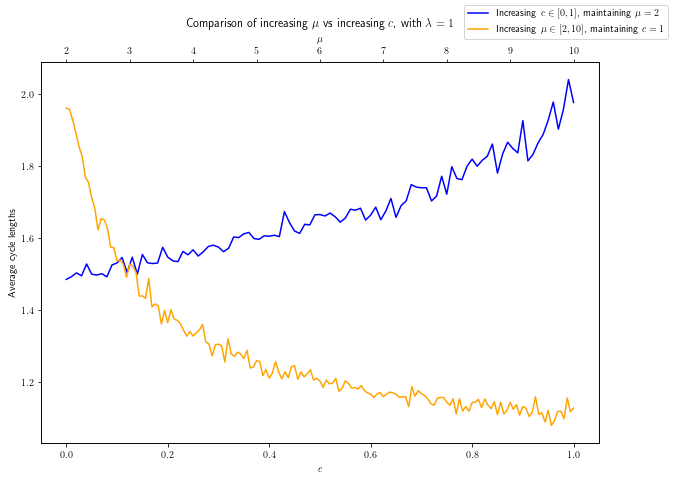

In [12]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax2 = ax1.twiny()

ax1.plot(
    x_c,
    y_c,
    color='blue',
    label='Increasing $c \in [0, 1]$, maintaining $\mu = 2$'
)
ax2.plot(
    x_mu,
    y_mu,
    color='orange',
    label=r'Increasing $\mu \in [2, 10]$, maintaining $c = 1$'
)

fig.legend()

ax1.set_xlabel(r'$c$')
ax2.set_xlabel(r'$\mu$')

ax1.set_ylabel('Average cycle lengths')
ax1.set_title(r'Comparison of increasing $\mu$ vs increasing $c$, with $\lambda = 1$')

### Plot number of cycles versus increasing $c$, $\mu$

Text(0.5, 1.0, 'Comparison of increasing $\\mu$ vs increasing $c$, with $\\lambda = 1$')

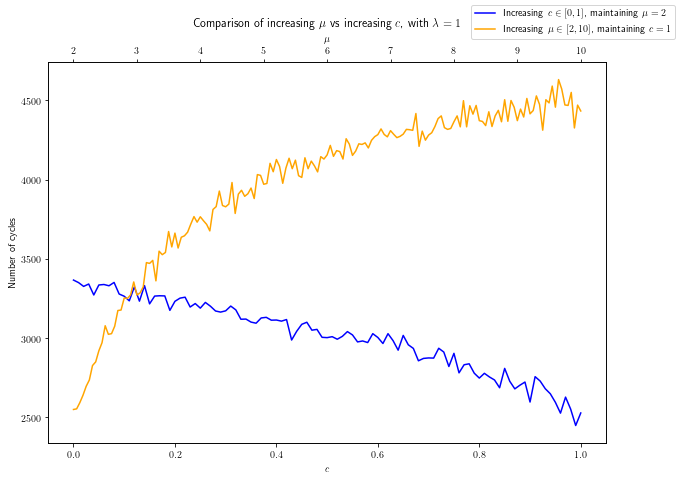

In [13]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax2 = ax1.twiny()

ax1.plot(
    x_c,
    y_cycles_c,
    color='blue',
    label='Increasing $c \in [0, 1]$, maintaining $\mu = 2$'
)

ax2.plot(
    x_mu,
    y_cycles_mu,
    color='orange',
    label=r'Increasing $\mu \in [2, 10]$, maintaining $c = 1$'
)

fig.legend()

ax1.set_xlabel(r'$c$')
ax2.set_xlabel(r'$\mu$')

ax1.set_ylabel('Number of cycles')
ax1.set_title(r'Comparison of increasing $\mu$ vs increasing $c$, with $\lambda = 1$')